# SAN - Praktische Arbeit (Marvel Universe Social Network)

## Netzwerkanalyse

In [165]:
import os
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite, centrality, community
import matplotlib.pyplot as plt

from helper import *

### Daten einlesen

In [166]:
nodes_df = pd.read_csv('Daten/nodes.csv')
edges_df = pd.read_csv('Daten/edges.csv')
df_heros = pd.read_csv('Daten/hero-network.csv')

### Initiales Netzwerk

Hier erstellen wir ein initiales ungerichtetes Netzwerk mit allen Verbindungen, ohne Filterungen.

In [167]:
heroes_df = nodes_df[nodes_df['type'] == 'hero']

B = nx.Graph()

B.add_nodes_from(heroes_df['node'])
B.add_edges_from(edges_df[['hero', 'comic']].values)
B.name = 'Marvel Universe'

print_network_information(B)

Information for given Graph with name 'Marvel Universe':
	Graph is directed: False
	Number of nodes: 19091
	Number of edges: 96104


In diesem Netzwerk gibt es keine direkten Verbindungen zwischen Helden oder zwischen Comics untereinander. Stattdessen sind die Helden mit Comics verbunden, was anzeigt, in welchen Comics die jeweiligen Helden erscheinen. Diese Struktur ist typisch für bipartite Netzwerke, in denen die beiden Knotentypen unterschiedliche Entitäten darstellen (in diesem Fall Helden und Comics) und die Kanten die Beziehungen zwischen diesen Entitäten repräsentieren.

### One-Mode-Netzwerk

Da das Netzwerk sehr gross ist, würden die Berechnungen und Darstellungen sehr lange dauern. Deshalb haben wir uns entschieden, das Netzwerk in ein One-Mode-Netzwerk umzuwandeln, in dem die Helden direkt miteinander verbunden sind, wenn sie in mindestens einem Comic gemeinsam auftreten. Dieses Netzwerk ist zwar nicht mehr bipartit, aber es enthält alle relevanten Informationen, die wir für die Analyse benötigen.

Dazu werden wir auch nur die 100 am häufigsten vorkommenden Helden berücksichtigen, um die Berechnungen zu beschleunigen. 

In [168]:
top_heroes = edges_df['hero'].value_counts().head(100).index.tolist()
top_heroes[:5]

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK']

## Frage 1 - Welche Helden sind die zentralsten im Netzwerk?

Um die Frage zu beantworten, welche Helden die zentralsten im Netzwerk sind, werden wir die drei genannten Zentralitätsmaße verwenden: Degree-Centrality, Betweenness-Centrality und Closeness-Centrality. Diese Maße geben jeweils unterschiedliche Aspekte der Zentralität eines Knotens im Netzwerk an:
- Degree-Centrality misst die Anzahl der direkten Verbindungen, die ein Knoten hat. Für Helden in unserem Netzwerk bedeutet ein hoher Wert, dass sie in vielen verschiedenen Comics erscheinen.
- Betweenness-Centrality gibt an, wie oft ein Knoten auf den kürzesten Pfaden zwischen anderen Knoten liegt. Ein hoher Wert deutet darauf hin, dass der Held eine wichtige Rolle in der Verbindung verschiedener Teile des Netzwerks spielt.
- Closeness-Centrality misst, wie nahe ein Knoten im Durchschnitt zu allen anderen Knoten im Netzwerk liegt. Ein hoher Wert zeigt an, dass ein Held im Durchschnitt schneller mit anderen Knoten verbunden werden kann.

Da das Netzwerk bipartit ist, muss beachtet werden, dass Closeness-Centrality für große Netzwerke möglicherweise nicht gut definiert ist, da nicht alle Knoten miteinander verbunden sind (Helden sind nur mit Comics verbunden, nicht direkt mit anderen Helden). Trotzdem führen wir die Analyse für alle drei Maße durch.

### Ganzes Netzwerk

In [169]:
B = nx.Graph()
B.add_nodes_from(nodes_df[nodes_df['type'] == 'hero']['node'], bipartite=0, type='hero')
B.add_nodes_from(nodes_df[nodes_df['type'] == 'comic']['node'], bipartite=1, type='comic')
B.add_edges_from(edges_df.values)

# Calculate degree centrality
degree_centrality = nx.degree_centrality(B)

# Sort the dictionary by degree centrality
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a dictionary
top_degree_centrality_dict = {hero: centrality for hero, centrality in top_degree_centrality}

for hero, centrality in top_degree_centrality_dict.items():
    print(f"{hero} hat eine Degree-Zentralität von {centrality:.3f}")

SPIDER-MAN/PETER PARKER hat eine Degree-Zentralität von 0.083
CAPTAIN AMERICA hat eine Degree-Zentralität von 0.070
IRON MAN/TONY STARK hat eine Degree-Zentralität von 0.060
THING/BENJAMIN J. GR hat eine Degree-Zentralität von 0.050
THOR/DR. DONALD BLAK hat eine Degree-Zentralität von 0.050
HUMAN TORCH/JOHNNY S hat eine Degree-Zentralität von 0.046
MR. FANTASTIC/REED R hat eine Degree-Zentralität von 0.045
HULK/DR. ROBERT BRUC hat eine Degree-Zentralität von 0.044
WOLVERINE/LOGAN hat eine Degree-Zentralität von 0.043
INVISIBLE WOMAN/SUE hat eine Degree-Zentralität von 0.040


### Netzwerk mit nur den 100 häufigsten Helden

weil datensatz so riesig ist und die laufzeit so lange ist haben wir nur die top 100 berücksichtigt

In [170]:
# Ermitteln der Top 100 Helden basierend auf der Anzahl der Erscheinungen
top_heroes = edges_df['hero'].value_counts().head(100).index

# Erstellen eines bipartiten Graphen
G = nx.Graph()
G.add_nodes_from(nodes_df['node'])
G.add_edges_from(edges_df[['hero', 'comic']].values)

# Erstellen einer One-Mode-Projektion des Graphen, die nur die Top 100 Helden enthält
top_heroes_subgraph = nx.bipartite.weighted_projected_graph(G, top_heroes)

# Berechnung der Zentralitätsmaße für den One-Mode-Subgraphen
degree_centrality = nx.degree_centrality(top_heroes_subgraph)
betweenness_centrality = nx.betweenness_centrality(top_heroes_subgraph)
closeness_centrality = nx.closeness_centrality(top_heroes_subgraph)

# Sort the dictionaries by centrality
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

top_degree_centrality[:5], top_betweenness_centrality[:5], top_closeness_centrality[:5]

([('CAPTAIN AMERICA', 0.32470389170896785),
  ('SPIDER-MAN/PETER PARKER', 0.2967851099830795),
  ('IRON MAN/TONY STARK', 0.2649746192893401),
  ('THING/BENJAMIN J. GR', 0.24500846023688663),
  ('MR. FANTASTIC/REED R', 0.23959390862944163)],
 [('SPIDER-MAN/PETER PARKER', 0.08742933210238858),
  ('CAPTAIN AMERICA', 0.07111762293161948),
  ('IRON MAN/TONY STARK', 0.046987566678910485),
  ('WOLVERINE/LOGAN', 0.04574329086892062),
  ('HAVOK/ALEX SUMMERS', 0.045018174043208826)],
 [('CAPTAIN AMERICA', 0.5969094030905969),
  ('SPIDER-MAN/PETER PARKER', 0.5863095238095238),
  ('IRON MAN/TONY STARK', 0.5742882130016519),
  ('THING/BENJAMIN J. GR', 0.5698033166216737),
  ('MR. FANTASTIC/REED R', 0.5680507497116494)])

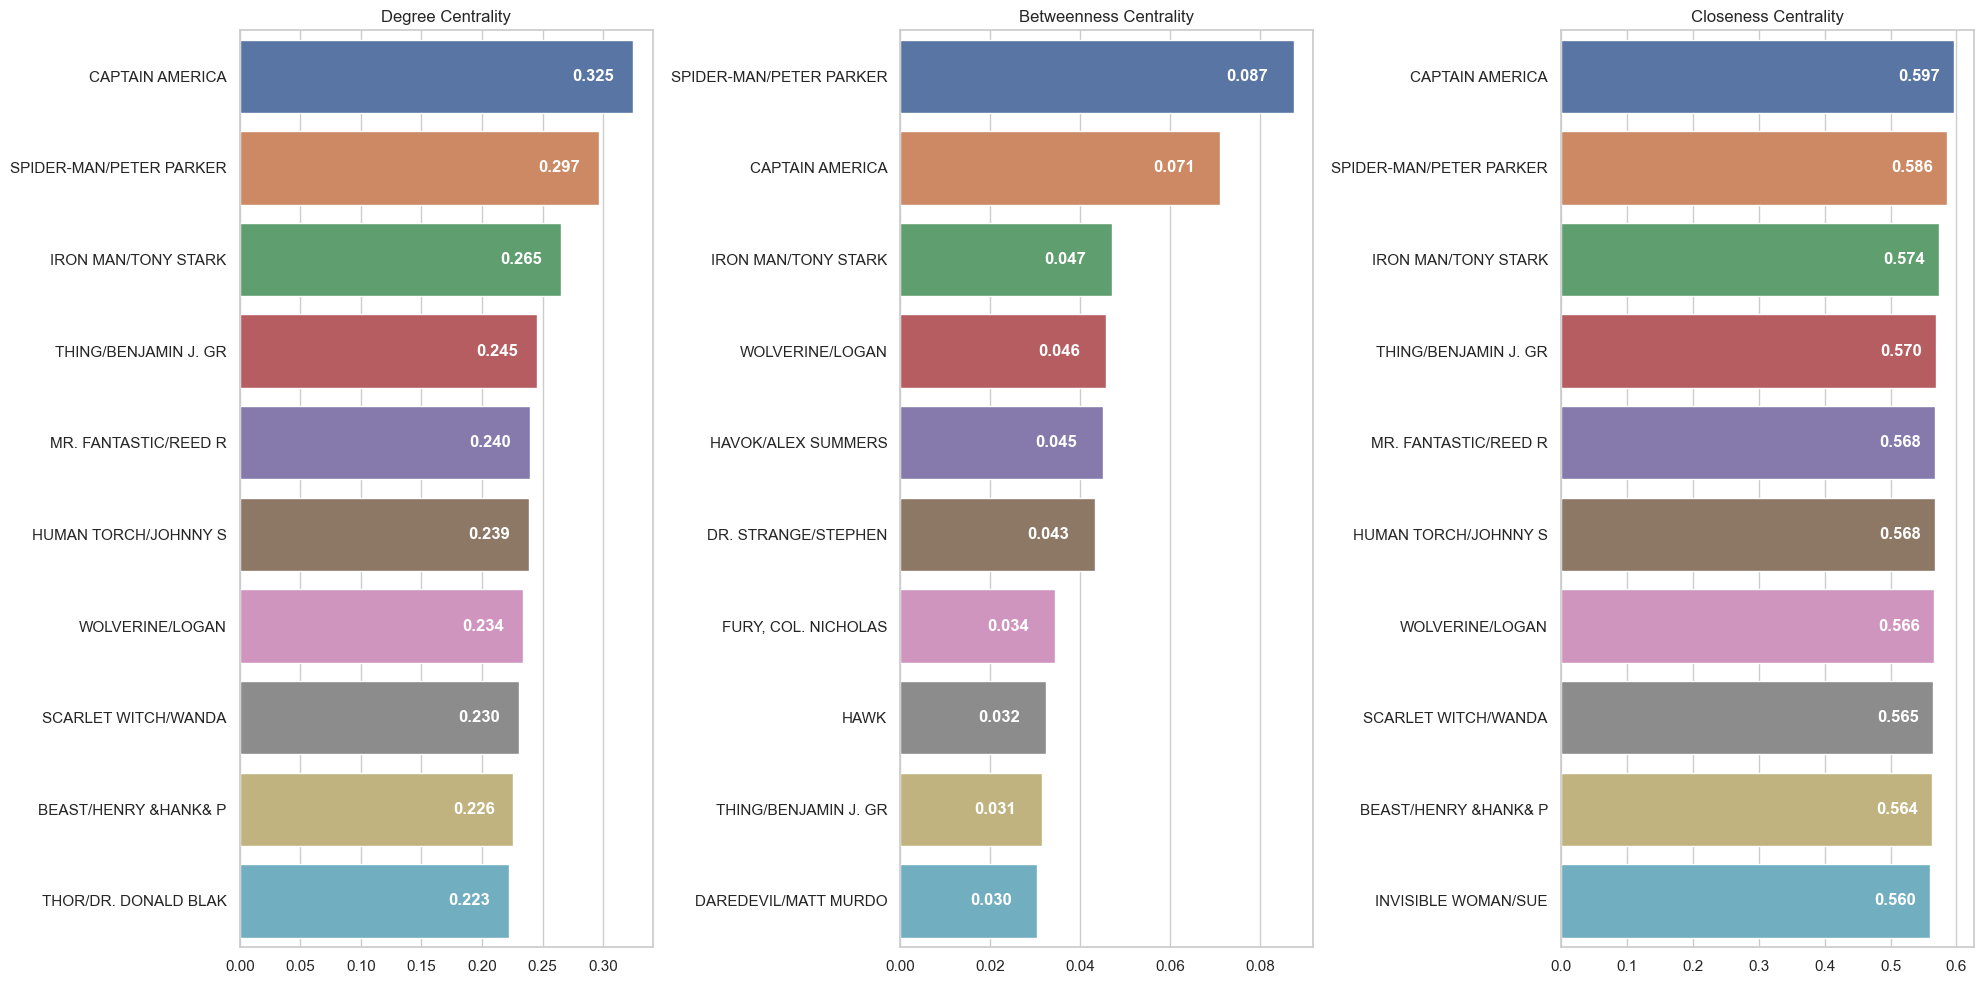

In [171]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Plot the degree centrality distribution
sns.barplot(y=[hero for hero, centrality in top_degree_centrality[:10]],
            x=[centrality for hero, centrality in top_degree_centrality[:10]],
            ax=ax[0])
ax[0].set_title('Degree Centrality')

for i, (hero, centrality) in enumerate(top_degree_centrality[:10]):
    ax[0].text(centrality - 0.05, i, f"{centrality:.3f}", va='center', color='white', fontweight='bold')

# Plot the betweenness centrality distribution
sns.barplot(y=[hero for hero, centrality in top_betweenness_centrality[:10]],
            x=[centrality for hero, centrality in top_betweenness_centrality[:10]],
            ax=ax[1])
ax[1].set_title('Betweenness Centrality')

for i, (hero, centrality) in enumerate(top_betweenness_centrality[:10]):
    ax[1].text(centrality -0.015, i, f"{centrality:.3f}", va='center', color='white', fontweight='bold')

# Plot the closeness centrality distribution
sns.barplot(y=[hero for hero, centrality in top_closeness_centrality[:10]],
            x=[centrality for hero, centrality in top_closeness_centrality[:10]],
            ax=ax[2])
ax[2].set_title('Closeness Centrality')

for i, (hero, centrality) in enumerate(top_closeness_centrality[:10]):
    ax[2].text(centrality -0.085, i, f"{centrality:.3f}", va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

## Frage 2 - Wie ist die Verteilung der Anzahl der Comics pro Held?

In [ ]:
# Count the number of mentions for each hero
hero_mentions = df_edges['hero'].value_counts()
top_heroes = hero_mentions.head(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Top 10 most frequent comics
sns.barplot(x=top_heroes.values, y=top_heroes.index, ax=axes[0])
axes[0].set_title('Top 10 am häufigsten vorkommende Helden in Comics')
axes[0].set_xlabel('Anzahl der Erwähnungen')
axes[0].set_ylabel('Helden')

# Distribution plot of mentions per comic
sns.histplot(hero_mentions, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Verteilung der Anzahl von Erwähnungen pro Held')
axes[1].set_xlabel('Anzahl der Erwähnungen')
axes[1].set_ylabel('Anzahl der Helden')

plt.tight_layout()
plt.show()

## Frage 3 - Gibt es Gruppen oder Gemeinschaften von Helden, die häufig zusammen in Comics erscheinen?

### One-mode Projektion

In [172]:
# Filter the edges to include only the top 100 heroes 
top_edges_df = edges_df[edges_df['hero'].isin(top_heroes)]

G = nx.Graph()

# Add nodes with the node attribute "bipartite"
G.add_nodes_from(top_heroes, bipartite=0)  # Heroes
G.add_nodes_from(set(top_edges_df['comic']), bipartite=1)  # Comics

# Add edges with weights based on the number of shared comics
for hero, df in top_edges_df.groupby('hero'):
    for comic in df['comic']:
        if G.has_edge(hero, comic):
            G[hero][comic]['weight'] += 1
        else:
            G.add_edge(hero, comic, weight=1)

# Create a one-mode projection of the graph where nodes are heroes
# and edges represent the number of comics they both appear in
G_one_mode = nx.bipartite.weighted_projected_graph(G, top_heroes)

# Extract the weights for the edges and sort them to find the strongest connections
weights = nx.get_edge_attributes(G_one_mode, 'weight')
sorted_weights = sorted(weights.items(), key=lambda item: item[1], reverse=True)

# Output the graph edges with weights and the strongest connections
sorted_weights[:10], list(G_one_mode.edges(data=True))[:10]

([(('THING/BENJAMIN J. GR', 'HUMAN TORCH/JOHNNY S'), 724),
  (('HUMAN TORCH/JOHNNY S', 'MR. FANTASTIC/REED R'), 694),
  (('THING/BENJAMIN J. GR', 'MR. FANTASTIC/REED R'), 690),
  (('MR. FANTASTIC/REED R', 'INVISIBLE WOMAN/SUE'), 682),
  (('HUMAN TORCH/JOHNNY S', 'INVISIBLE WOMAN/SUE'), 675),
  (('THING/BENJAMIN J. GR', 'INVISIBLE WOMAN/SUE'), 650),
  (('SPIDER-MAN/PETER PARKER', 'WATSON-PARKER, MARY'), 614),
  (('SPIDER-MAN/PETER PARKER', 'JAMESON, J. JONAH'), 514),
  (('CAPTAIN AMERICA', 'IRON MAN/TONY STARK'), 440),
  (('SCARLET WITCH/WANDA', 'VISION'), 426)],
 [('SPIDER-MAN/PETER PARKER', 'ANT-MAN/DR. HENRY J.', {'weight': 46}),
  ('SPIDER-MAN/PETER PARKER', 'SPIDER-MAN CLONE/BEN', {'weight': 98}),
  ('SPIDER-MAN/PETER PARKER', 'BLACK KNIGHT V/DANE', {'weight': 21}),
  ('SPIDER-MAN/PETER PARKER', 'GAMBIT/REMY LEBEAU', {'weight': 9}),
  ('SPIDER-MAN/PETER PARKER', 'WATSON-PARKER, MARY', {'weight': 614}),
  ('SPIDER-MAN/PETER PARKER', 'SUNSPOT/ROBERTO DACO', {'weight': 8}),
  ('SPIDER

Wir sehen hier die stärksten Verbindungen zwischen den einzelnen Helden. Vorallem stark sind die von den Fantastic Four. 

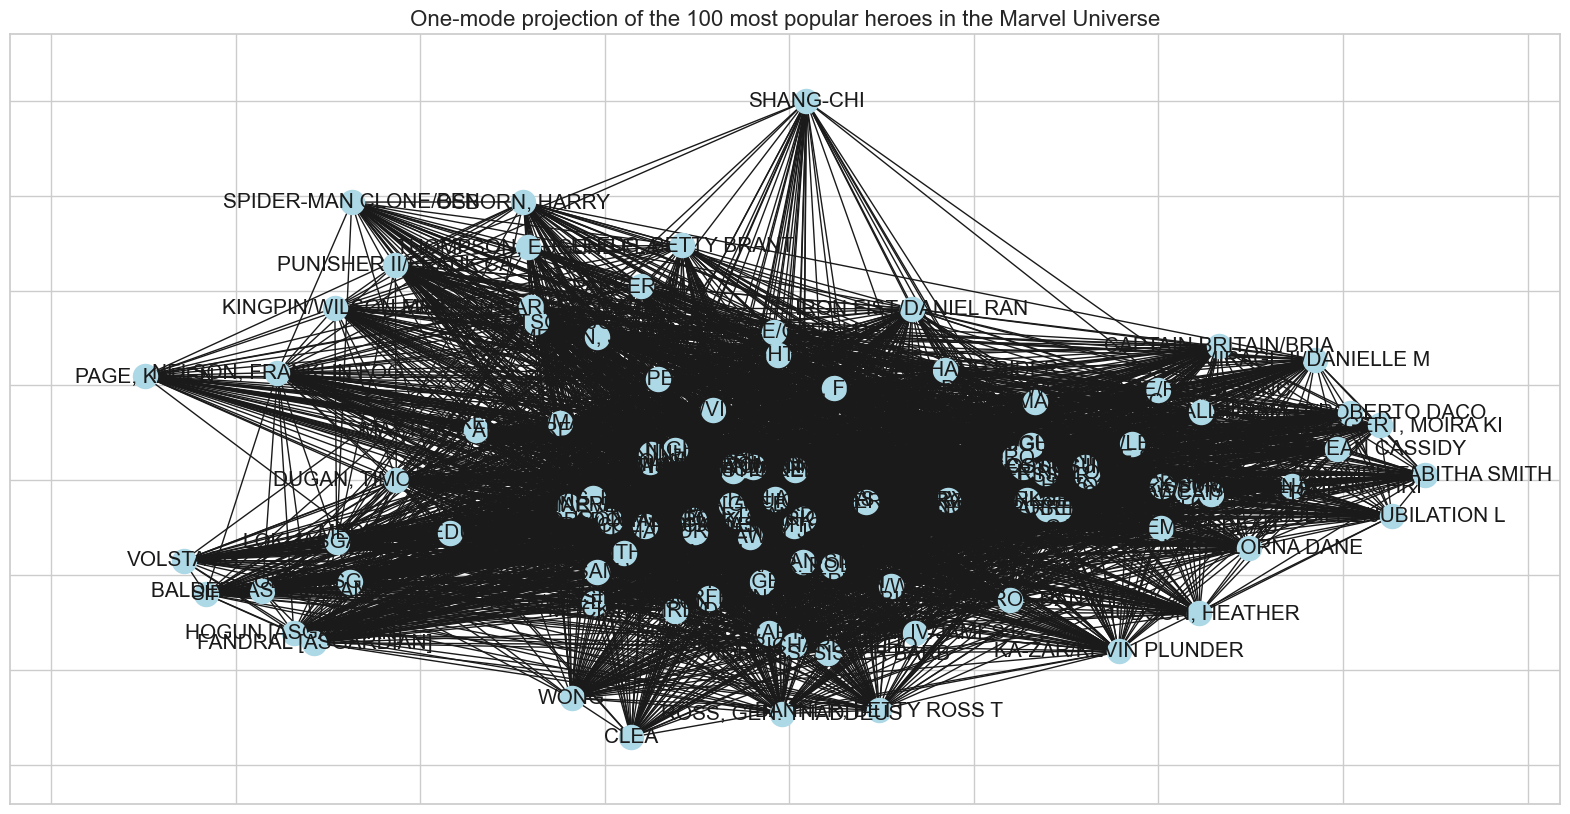

In [173]:
plt.figure(figsize=(20, 10))
plt.title("One-mode projection of the 100 most popular heroes in the Marvel Universe", fontsize=16)
draw_graph_and_color_groups(G_one_mode, layout="spring")

### Communities

wie funktioniert greedy modularity? 
- community.girvan_newman ausprobieren
- Edge Betweenness berechnen
- Edge Betweeness Clustering

In [174]:
communities = community.greedy_modularity_communities(G_one_mode)
len(communities)

2

Bei der Community Detection haben wir uns für die Greedy Modularity Methode entschieden. Diese Methode ist sehr schnell und lieferte 2 verschiedene Communities.

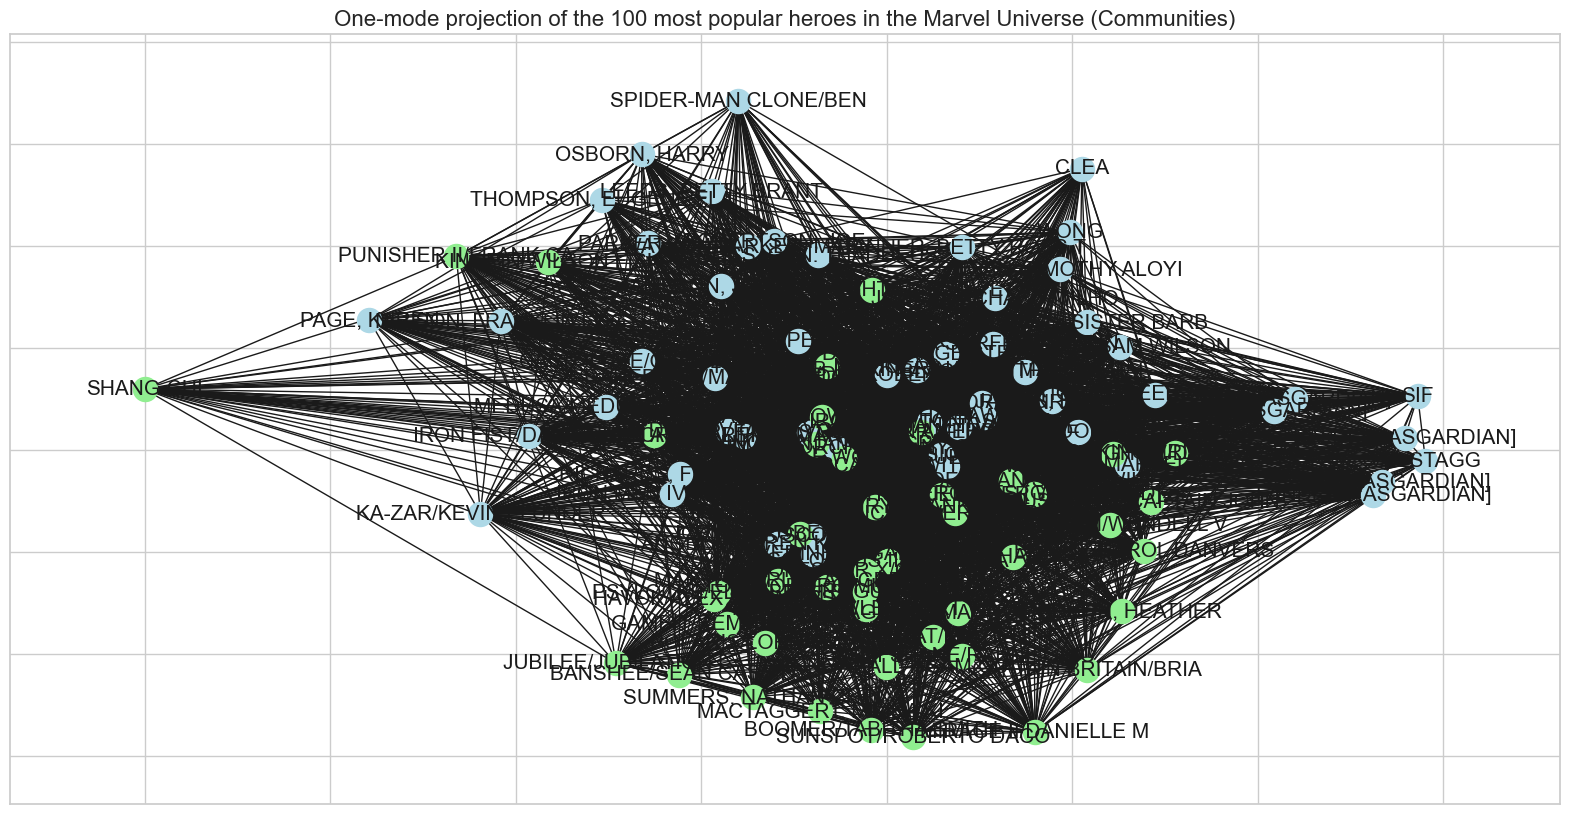

In [175]:
plt.figure(figsize=(20, 10))
plt.title("One-mode projection of the 100 most popular heroes in the Marvel Universe (Communities)", fontsize=16)
draw_graph_and_color_groups(G_one_mode, communities, layout="spring")

## Frage 4 - Identifizierung von Helden mit einem Grad von 1
- Berechne den Grad jedes Helden im Netzwerk.
- Filtere die Liste, um nur die Helden zu behalten, deren Grad gleich 1 ist.
- Diese Liste gibt die Helden, die nur in einem einzigen Comic erscheinen.

In [176]:
# Calculate degree
degrees = {hero: B.degree(hero) for hero in B.nodes()}

# Filter out the heroes with only one comic
heroes_with_one_comic = [hero for hero, deg in degrees.items() if deg == 1]

print("Anzahl Helden im gesamten Datensatz, welche nur in einem einzigen Comic erscheinen:", len(heroes_with_one_comic))
print(heroes_with_one_comic[:5])

Anzahl Helden im gesamten Datensatz, welche nur in einem einzigen Comic erscheinen: 3275
['24-HOUR MAN/EMMANUEL', 'ABBOTT, JACK', 'ABOMINATION | MUTANT', 'ABSORBING MAN | MUTA', 'ACBA']


In [177]:
# Filtern nach Helden mit dem höchsten Grad
top_degree_hero, degree = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[0]
print(top_degree_hero + " hat den höchsten Grad mit " + str(degree) + " Comics.")

SPIDER-MAN/PETER PARKER hat den höchsten Grad mit 1577 Comics.


# comics als nodes und zentralitäten und so berechnen, communities etc

# in welchem comics die meisten superhelden sind (top 100 comics)

# comic übereinstimmungen -> fortsetzungen?

# Welche helden kommen in allen COC comics vor?

# Link Prediction -> welche helden könnten in einem comic zusammen auftreten?